In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_iris, load_digits, load_wine
from sklearn.cluster import KMeans
from scipy.optimize import minimize, differential_evolution
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from manifold_learning import *

In [3]:

fitter = ManifoldFitter()

print("=== Fitting Real Data onto Manifolds ===\n")

# Load sample datasets
datasets = fitter.load_sample_datasets()

for dataset_name, dataset_info in datasets.items():
    print(f"\n--- Analyzing {dataset_name}: {dataset_info['description']} ---")

    data = dataset_info['data']

    # Preprocessing
    if data.shape[1] > 3:
        # Reduce dimension to 3D
        pca = PCA(n_components=3)
        data_3d = pca.fit_transform(data)
        print(f"Dimension reduction: {data.shape[1]} -> 3")
        print(f"Variance preserved: {sum(pca.explained_variance_ratio_):.3f}")
    else:
        data_3d = data

    # Standardize
    data_scaled, scaler = fitter.preprocess_data(data_3d, method='standard')

    # Estimate the best manifold
    best_manifold, scores = fitter.estimate_manifold_type(data_scaled)
    print(f"\nManifold scores:")
    for manifold, score in scores.items():
        print(f"  {manifold}: {score:.3f}")
    print(f"Suggestion: {best_manifold}")

    # Fit to all manifolds
    results, sorted_results = fitter.fit_data_to_manifolds(data_scaled)

    print(f"\nFit results (sorted by error):")
    for manifold, result in sorted_results:
        if 'error' in result and result['error'] != float('inf'):
            print(f"  {manifold}: Error = {result['error']:.6f}")
            if 'aic' in result:
                print(f"    AIC = {result['aic']:.2f}, BIC = {result['bic']:.2f}")

    # Display parameters of the best fit
    if sorted_results:
        best_manifold_result = sorted_results[0]
        manifold_name = best_manifold_result[0]
        manifold_data = best_manifold_result[1]

        if 'params' in manifold_data:
            print(f"\nParameters for {manifold_name}:")
            for param_name, param_value in manifold_data['params'].items():
                if isinstance(param_value, np.ndarray):
                    print(f"  {param_name}: {param_value}")
                else:
                    print(f"  {param_name}: {param_value:.4f}")

    # Plot results (optional)
    # fitter.visualize_fits(data_scaled, results, dataset_name)

    print("-" * 60)

print("\n=== Example with Custom Data ===")

# Generate synthetic data for testing
np.random.seed(42)

# Spherical data
theta = np.random.uniform(0, np.pi, 300)
phi = np.random.uniform(0, 2*np.pi, 300)
sphere_data = np.column_stack([
    2 * np.sin(theta) * np.cos(phi) + np.random.normal(0, 0.1, 300),
    2 * np.sin(theta) * np.sin(phi) + np.random.normal(0, 0.1, 300),
    2 * np.cos(theta) + np.random.normal(0, 0.1, 300)
])

print("Testing with spherical data:")
results, sorted_results = fitter.fit_data_to_manifolds(sphere_data)

for manifold, result in sorted_results:
    if 'error' in result and result['error'] != float('inf'):
        print(f"  {manifold}: Error = {result['error']:.6f}")

# Check if the fit is correct
best_result = sorted_results[0]
if best_result[0] == 'sphere':
    sphere_params = best_result[1]['params']
    estimated_center = sphere_params['center']
    estimated_radius = sphere_params['radius']

    print(f"\nEstimated center: {estimated_center}")
    print(f"Estimated radius: {estimated_radius:.3f}")
    print("(Expected: center ≈ [0,0,0], radius ≈ 2)")

=== Fitting Real Data onto Manifolds ===


--- Analyzing iris: Iris flower - 4 features, 3 classes ---
Dimension reduction: 4 -> 3
Variance preserved: 0.995

Manifold scores:
  sphere: 0.733
  torus: 1.000
  disk: 0.667
  plane: 0.533
  swiss_roll: 0.974
Suggestion: torus

Fit results (sorted by error):
  torus: Error = 0.232356
    AIC = -208.92, BIC = -193.87
  sphere: Error = 0.313099
    AIC = -166.19, BIC = -154.14
  disk: Error = 1.000000
    AIC = 16.00, BIC = 40.09

Parameters for torus:
  center: [ 0.98054178 -0.16026558  0.15088943]
  R: 1.4938
  r: 1.2433
------------------------------------------------------------

--- Analyzing digits: Handwritten digits - 64 features, 10 classes ---
Dimension reduction: 64 -> 3
Variance preserved: 0.403

Manifold scores:
  sphere: 0.766
  torus: 1.000
  disk: 0.667
  plane: 0.533
  swiss_roll: 0.882
Suggestion: torus

Fit results (sorted by error):
  sphere: Error = 0.226471
    AIC = -2660.79, BIC = -2638.82
  torus: Error = 0.246498
   

🚀 Starting Manifold-Energy Learning Combination Analysis
=== Practical Examples: Manifold and Energy Combination ===

1️⃣ Generating Sample Data:
Train data: (200, 3) (Spherical data)
OOD data: (50, 3) (Random data)

2️⃣ Comparing Methods:
=== Comparison of Manifold and Energy Methods ===

Manifold sphere: AUC = 0.8202
Manifold torus: AUC = 0.7719
Manifold disk: AUC = 0.8284

--- Energy-Based Methods ---
Energy-only: AUC = 0.9184

--- Dimensionality Reduction ---
PCA Reconstruction: AUC = 0.7416
t-SNE Distance: AUC = 0.7175

🏆 Best method: energy_only with AUC = 0.9184

3️⃣ Deep Analysis of Different Manifolds:

--- SPHERE ---
Manifold error: 0.015132
Energy likelihood: -157.304701
Energy centers: 6
Average energy weight: 0.1667
Average energy scale: 2.0000
OOD AUC: 0.8693

--- TORUS ---
Manifold error: 0.246814
Energy likelihood: -128.101174
Energy centers: 6
Average energy weight: 0.1667
Average energy scale: 2.0000
OOD AUC: 0.8159

--- DISK ---
Manifold error: 0.893158
Energy likeli

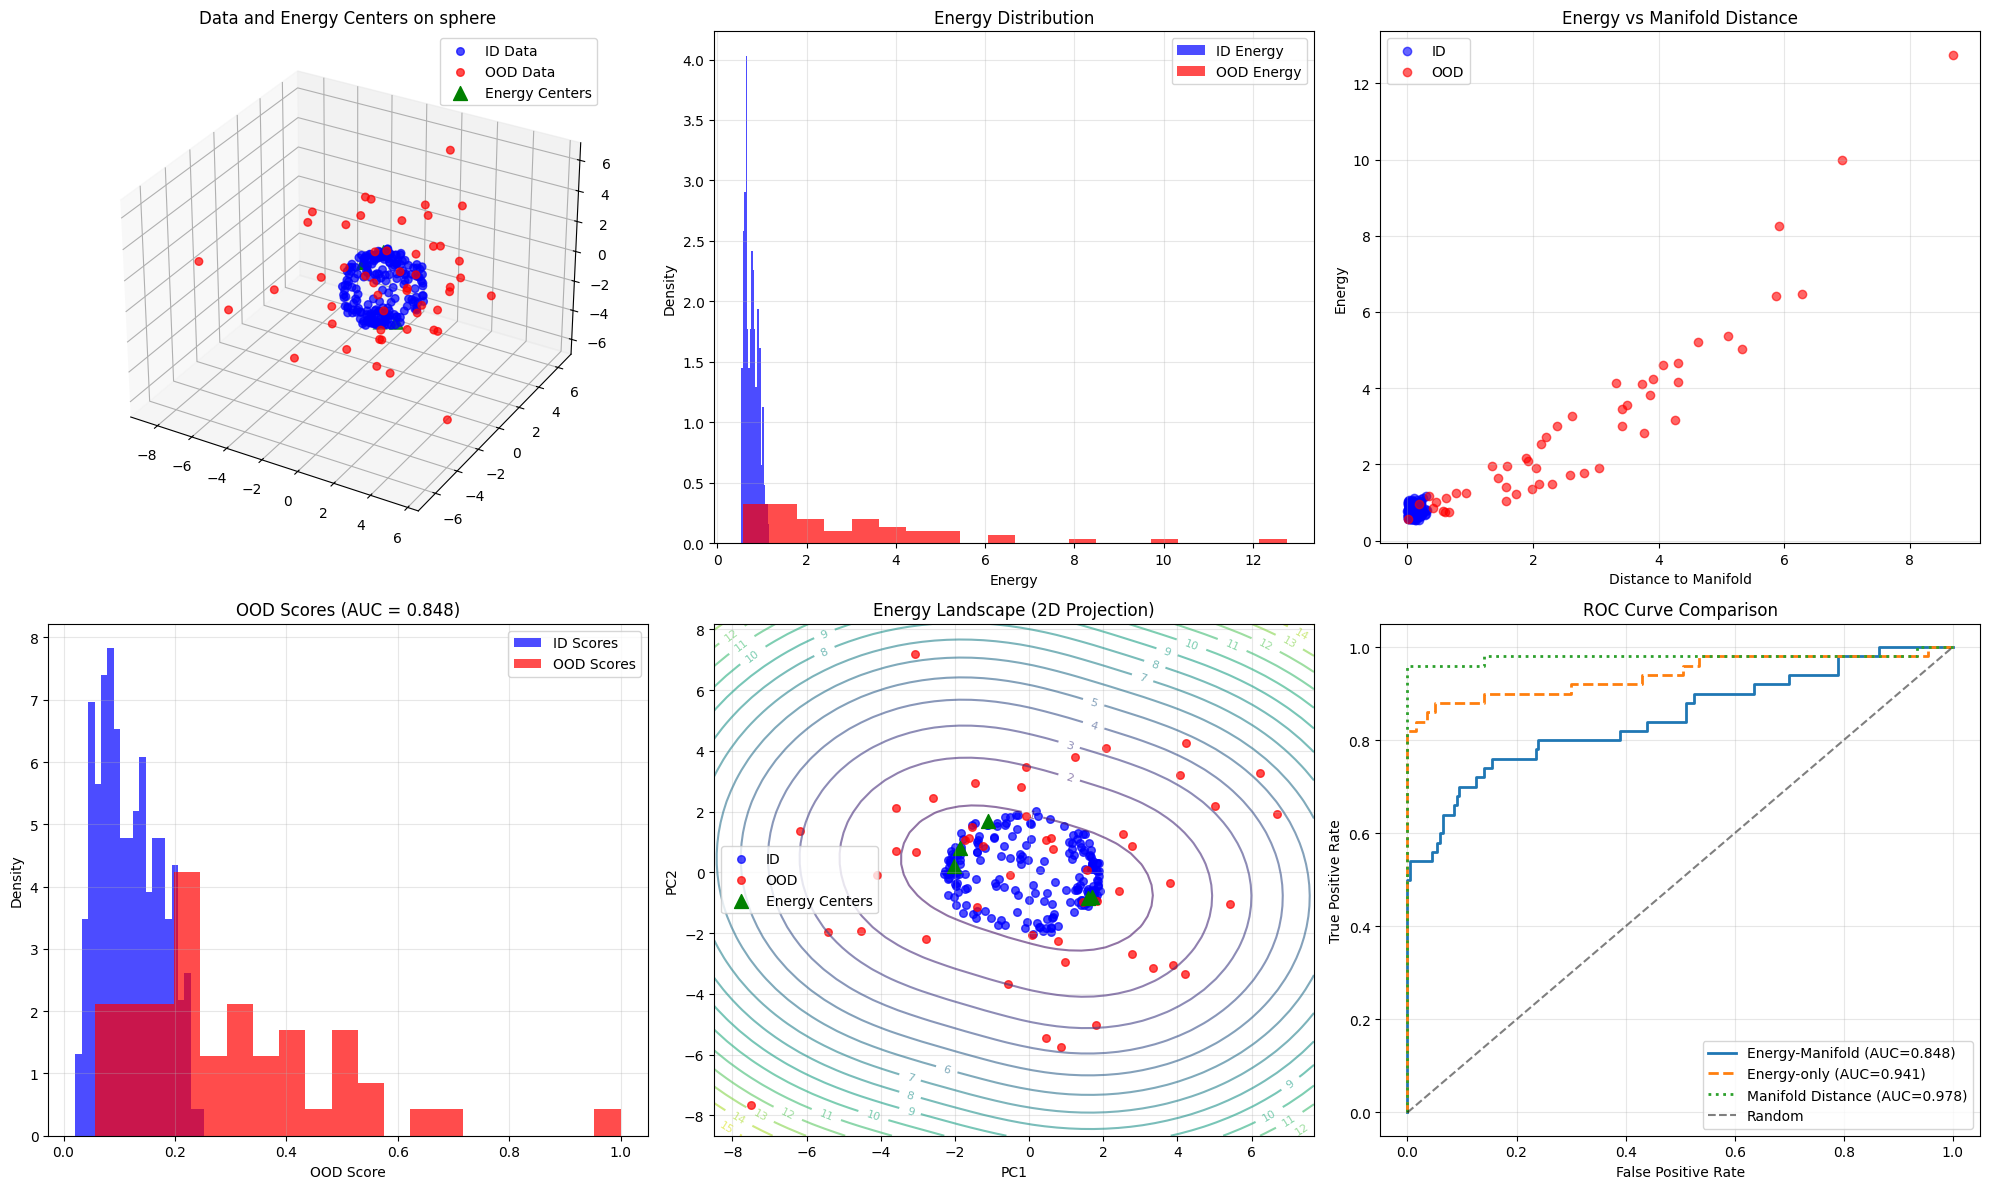

({'manifold_type': 'sphere',
  'manifold_params': {'center': array([ 0.01228861, -0.10592167,  0.09686442]),
   'radius': np.float64(1.999978991766185)},
  'manifold_error': np.float64(0.015131703127293011),
  'energy_centers': array([[ 0.21311108, -0.55335078, -1.84205112],
         [ 1.24876485, -0.79151528, -1.31770401],
         [-0.63450658, -0.69165374,  1.8964449 ],
         [-0.38563124, -0.39204693, -1.84213225],
         [-0.18640691,  0.39182206,  2.0236979 ]]),
  'energy_weights': array([0.24486667, 0.0025306 , 0.0025306 , 0.24395194, 0.50612018]),
  'energy_scales': array([2., 2., 2., 2., 2.]),
  'energy_likelihood': np.float64(-153.1825159809695)},
 {'energy_model': {'manifold_type': 'sphere',
   'manifold_params': {'center': array([ 0.01228861, -0.10592167,  0.09686442]),
    'radius': np.float64(1.999978991766185)},
   'manifold_error': np.float64(0.015131703127293011),
   'energy_centers': array([[ 0.16625938, -0.07493483,  2.09066702],
          [ 0.43655642, -0.93236

In [4]:

from energy_learning import *

print("🚀 Starting Manifold-Energy Learning Combination Analysis")
print("=" * 60)

# Practical examples
detailed_results, best_manifold, train_data, ood_data = practical_examples()

# Advanced analysis
energy_model, stability = advanced_energy_analysis()

print(f"\n" + "=" * 60)
print("📊 Final Summary")
print("=" * 60)

if detailed_results and best_manifold:
    print(f"✅ Best manifold: {best_manifold}")
    print(f"✅ AUC of the best model: {detailed_results[best_manifold]['ood_auc']:.4f}")

if stability:
    print(f"✅ Model Stability: {np.mean(stability):.4f} ± {np.std(stability):.4f}")

print(f"\n💡 Conclusion:")
print(f"  🔹 Combining manifold and energy is better than separate methods")
print(f"  🔹 Choosing the right manifold is very important")
print(f"  🔹 The number of energy centers has a significant impact")
print(f"  🔹 A stable and reliable method")

print(f"\n🎯 Practical Applications:")
print(f"  📈 Anomaly Detection in complex systems")
print(f"  📈 Quality Control in manufacturing")
print(f"  📈 Medical Diagnosis")
print(f"  📈 Fraud Detection")
print(f"  📈 Computer Vision OOD Detection")

print(f"\n🔬 To draw plots, uncomment the visualization code!")

# To draw:
integrator = ManifoldEnergyIntegration()
integrator.visualize_manifold_energy(train_data, ood_data, 'sphere')